In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

d:\projects\git-hub\Full-Autoencoder-implemented-in-PyTorch\utils.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x # just throw away the original label.

In [6]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [7]:
def get_layer(in_size,out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Linear(in_size,out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )

In [8]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    get_layer(D,D//2),
    get_layer(D//2,D//3),
    get_layer(D//3,D//4),
    nn.Linear(D//4,n)
)

auto_decoder = nn.Sequential(
    get_layer(n,D//4),
    get_layer(D//4,D//3),
    get_layer(D//3,D//2),
    nn.Linear(D//2,D),
    View(-1,1,28,28)
)

In [9]:
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [10]:
train_network(model=auto_encode_decode,loss_func=nn.MSELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=6,
            device=device)

Epoch: 100%|██████████| 6/6 [01:23<00:00, 13.84s/it]


,epoch,total time,train loss,test loss
0,0,14.389164,0.049889,0.043273
1,1,25.252111,0.043358,0.041444
2,2,37.194286,0.041951,0.040101
3,3,49.028595,0.041058,0.039847
4,4,61.735067,0.040560,0.039072
5,5,74.384555,0.040019,0.038661


In [11]:
def encode_batch(encoder,dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset,
    and `labels` are the original labels provided by the `dataset_to_encode`
    """
    projected = []
    labels = []
    # put the encode to evaluation mode and pass it to the cpu
    encoder = encoder.eval()
    encoder = encoder.cpu()
    with torch.inference_mode():
        for x,y in DataLoader(dataset_to_encode,batch_size=128):
            z = encoder(x.cpu()) # move x to cpu just in case it wasn't already there
            projected.append(z.numpy())
            labels.append(y.cpu().numpy().ravel())

    projected = np.vstack(projected)
    labels = np.hstack(labels)
    
    return projected , labels

In [12]:
projected , labels = encode_batch(auto_encode_decode,test_data_xy)
projected.shape , projected.ndim

((10000, 1, 28, 28), 4)

In [33]:
projected , labels = encode_batch(auto_encoder,test_data_xy)
projected.shape , projected.ndim

((10000, 2), 2)

In [37]:
projected[:,1].shape

(10000,)

<Axes: >

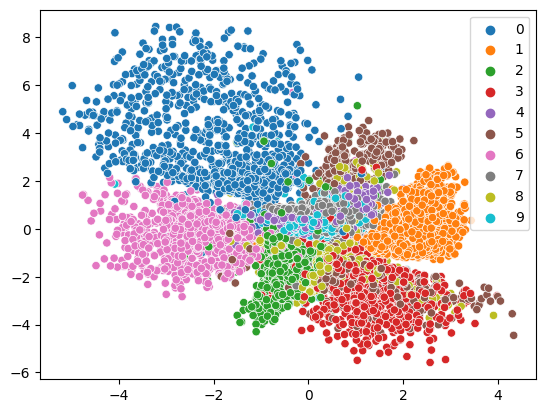

In [38]:
sns.scatterplot(
    x=projected[:,0],
    y=projected[:,1],
    hue=[str(l) for l in labels],
    hue_order=[str(i) for i in range(10)],
    legend="full")

In [39]:
def show_encode_decode(encode_decode,x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.inference_mode():
        x_recon = encode_decode(x.cpu())
        f , axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

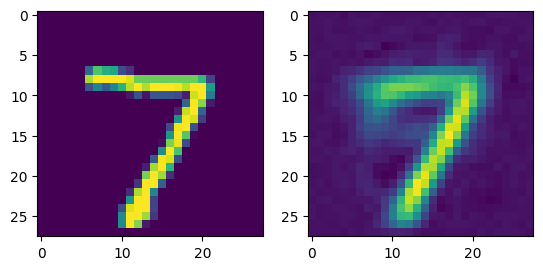

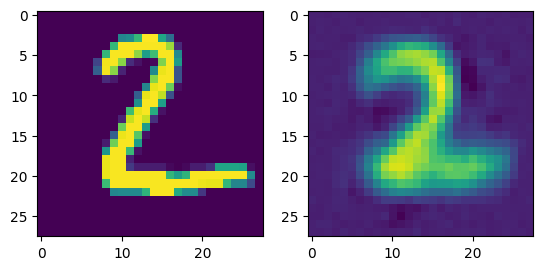

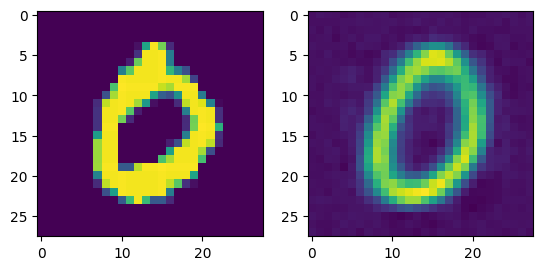

In [45]:
show_encode_decode(auto_encode_decode,test_data_xx[0][0])
show_encode_decode(auto_encode_decode,test_data_xx[1][0])
show_encode_decode(auto_encode_decode,test_data_xx[3][0])